<a href="https://colab.research.google.com/github/steimel60/ML/blob/main/DeepLearning/BearClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 719 kB 32.9 MB/s 
     |████████████████████████████████| 1.2 MB 57.0 MB/s 
     |████████████████████████████████| 197 kB 61.4 MB/s 
     |████████████████████████████████| 59 kB 5.5 MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *

#Get 100 urls of Grizzly bear images
urls = search_images_ddg('grizzly bear', max_images=100)
len(urls),urls[0]

(100, 'https://reidparkzoo.org/wp-content/uploads/2013/09/grzbear2812a.jpg')

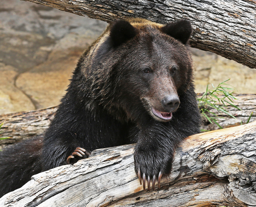

In [3]:
#Download and view image at the first url
download_url(urls[0], 'images/bear.jpg')
im = Image.open('images/bear.jpg')
im.thumbnail((256,256))
im

In [4]:
#Do this for each bear type

bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

if not path.exists():
  path.mkdir()
  for b in bear_types:
    dest = (path/b)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{b} bear', max_images=100)
    download_images(dest, urls=results)

fns = get_image_files(path)
fns

(#286) [Path('bears/teddy/00000039.jpg'),Path('bears/teddy/00000032.jpeg'),Path('bears/teddy/00000074.jpg'),Path('bears/teddy/00000083.jpeg'),Path('bears/teddy/00000021.jpg'),Path('bears/teddy/00000030.jpg'),Path('bears/teddy/00000053.jpg'),Path('bears/teddy/00000090.jpg'),Path('bears/teddy/00000068.jpg'),Path('bears/teddy/00000047.jpg')...]

In [5]:
#Remove corrupt downloads
failed = verify_images(fns)
failed.map(Path.unlink)

(#4) [None,None,None,None]